In [1]:
import os
from scipy.io import loadmat
import h5py

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load mat file data
mat = h5py.File(os.path.join("NYUv2", "nyu_depth_v2_labeled.mat"), 'r', libver='latest', swmr=True)

# Images are in 4D array (1449, 3, 640, 480), and depth maps are in 3D array (1449, 640, 480).
# We can simply transpose the axes to get them in a format suitable for training.

images = np.transpose(mat["images"], (0, 2, 3, 1))
depths = np.transpose(mat["depths"], (0, 2, 1))

# Shuffle data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
depths = depths[indices]

# Split data into training and validation
train_images = images[:1000]
train_depths = depths[:1000]
val_images = images[1000:]
val_depths = depths[1000:]

In [2]:
def crop_images(images, percentage):
    # The percentage should be between 0 and 1
    height, width = images.shape[1], images.shape[2]
    start_row = int(height * percentage / 2)
    end_row = height - start_row
    start_col = int(width * percentage / 2)
    end_col = width - start_col
    return images[:, start_row:end_row, start_col:end_col, :]

percentage = 0.20  

# Crop training images
train_images = crop_images(train_images, percentage)
val_images = crop_images(val_images, percentage)

In [3]:
print(train_images[0].shape)

(512, 384, 3)


In [4]:
# Extract depth value at the center
center_depths_train = train_depths[:, 320, 240]
center_depths_val = val_depths[:, 320, 240]

# normalize images for better network performance
train_images = train_images / 255.
val_images = val_images / 255.

# Reshape depths for suitable training 
center_depths_train = center_depths_train.reshape(-1, 1)
center_depths_val = center_depths_val.reshape(-1, 1)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import efficientnet.tfkeras as efn

# Define input shape based on your data
input_shape = (512, 384, 3)

# Load pre-trained EfficientNet and add custom layers on top
base_model = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)

# Set layers of base model to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(1)(x)

# Define the new model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [6]:
history = model.fit(train_images, center_depths_train, epochs=20, validation_data=(val_images, center_depths_val), batch_size = 32)

Epoch 1/20
32/32 [==============================] - 26s 451ms/step - loss: 1.5162 - val_loss: 1.1104
Epoch 2/20
32/32 [==============================] - 11s 348ms/step - loss: 0.8225 - val_loss: 0.9712
Epoch 3/20
32/32 [==============================] - 11s 352ms/step - loss: 0.6325 - val_loss: 0.9274
Epoch 4/20
32/32 [==============================] - 11s 351ms/step - loss: 0.5830 - val_loss: 0.9811
Epoch 5/20
32/32 [==============================] - 11s 352ms/step - loss: 0.5481 - val_loss: 0.9821
Epoch 6/20
32/32 [==============================] - 11s 352ms/step - loss: 0.5308 - val_loss: 1.0256
Epoch 7/20
32/32 [==============================] - 11s 355ms/step - loss: 0.4215 - val_loss: 0.9034
Epoch 8/20
32/32 [==============================] - 11s 356ms/step - loss: 0.3774 - val_loss: 0.9150
Epoch 9/20
32/32 [==============================] - 11s 359ms/step - loss: 0.4000 - val_loss: 0.9322
Epoch 10/20
32/32 [==============================] - 11s 358ms/step - loss: 0.3420 - val_lo

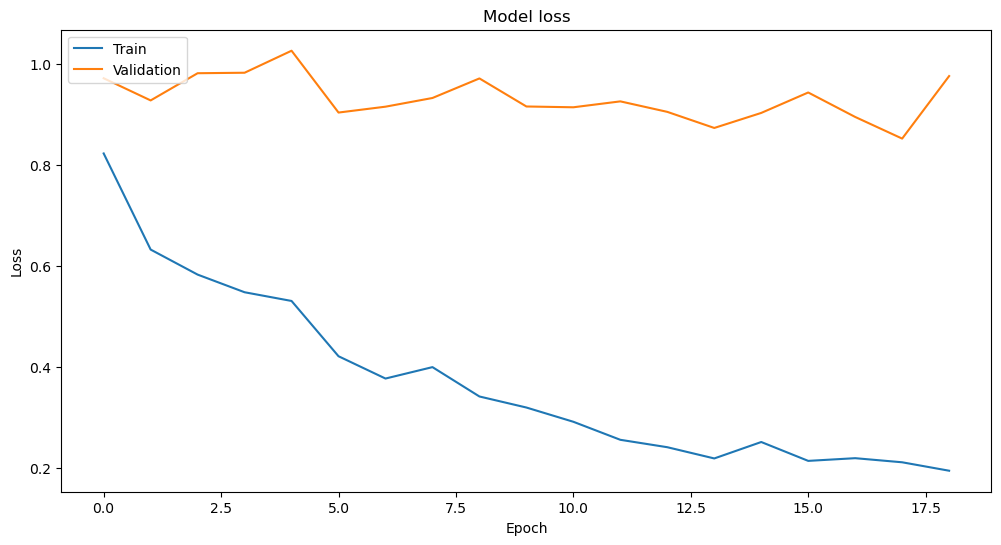

In [7]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the distances on the validation set
val_predictions = model.predict(val_images)

# Reshaping predictions and true values to one-dimensional arrays
val_predictions = val_predictions.reshape(-1)
true_values = center_depths_val.reshape(-1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae} meters")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, val_predictions)
print(f"Mean Squared Error (MSE): {mse} meters")

15/15 [==============================] - 6s 248ms/step
Mean Absolute Error (MAE): 0.7517268061637878 meters
Mean Squared Error (MSE): 0.9755246043205261 meters


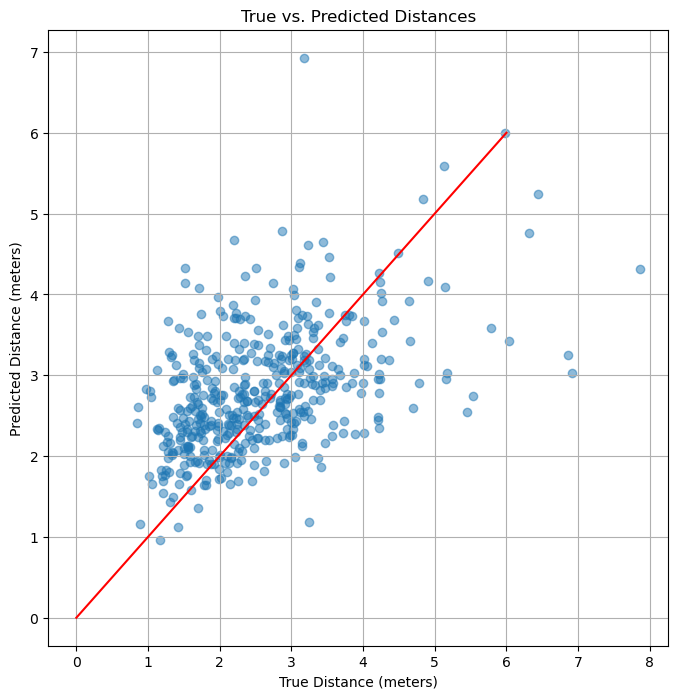

In [9]:
import matplotlib.pyplot as plt

# Scatter plot of true vs. predicted distances
plt.figure(figsize=(8, 8))
plt.scatter(true_values, val_predictions, alpha=0.5)
plt.plot([0, 6], [0, 6], color='red')  # Ideal model would follow this line
plt.xlabel('True Distance (meters)')
plt.ylabel('Predicted Distance (meters)')
plt.title('True vs. Predicted Distances')
plt.grid(True)
plt.show()

In [10]:
model.save('Distance_prediction_EfficientNet.h5')

In [5]:
import tensorflow as tf
import efficientnet.keras as efn

model = tf.keras.models.load_model('Distance_prediction_EfficientNet.h5')

In [6]:
# Freeze all layers in the base model
for layer in model.layers:
    layer.trainable = False

# Unfreeze the last layer
model.layers[-1].trainable = True
    
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='mean_squared_error')

history = model.fit(train_images, center_depths_train, epochs=100, validation_data=(val_images, center_depths_val),
                   batch_size = 32)


Epoch 1/100
32/32 [==============================] - 27s 446ms/step - loss: 0.4558 - val_loss: 0.4448
Epoch 2/100
32/32 [==============================] - 11s 338ms/step - loss: 0.4501 - val_loss: 0.4349
Epoch 3/100
32/32 [==============================] - 11s 337ms/step - loss: 0.4510 - val_loss: 0.4263
Epoch 4/100
32/32 [==============================] - 11s 339ms/step - loss: 0.4310 - val_loss: 0.4178
Epoch 5/100
32/32 [==============================] - 11s 339ms/step - loss: 0.4243 - val_loss: 0.4103
Epoch 6/100
32/32 [==============================] - 11s 344ms/step - loss: 0.4500 - val_loss: 0.4037
Epoch 7/100
32/32 [==============================] - 11s 345ms/step - loss: 0.4278 - val_loss: 0.3968
Epoch 8/100
32/32 [==============================] - 11s 344ms/step - loss: 0.4537 - val_loss: 0.3904
Epoch 9/100
32/32 [==============================] - 11s 344ms/step - loss: 0.4451 - val_loss: 0.3850
Epoch 10/100
32/32 [==============================] - 11s 343ms/step - loss: 0.422

32/32 [==============================] - 11s 354ms/step - loss: 0.4153 - val_loss: 0.3262
Epoch 81/100
32/32 [==============================] - 11s 356ms/step - loss: 0.4184 - val_loss: 0.3267
Epoch 82/100
32/32 [==============================] - 11s 354ms/step - loss: 0.4252 - val_loss: 0.3262
Epoch 83/100
32/32 [==============================] - 11s 355ms/step - loss: 0.4160 - val_loss: 0.3259
Epoch 84/100
32/32 [==============================] - 11s 357ms/step - loss: 0.3982 - val_loss: 0.3255
Epoch 85/100
32/32 [==============================] - 11s 355ms/step - loss: 0.4308 - val_loss: 0.3258
Epoch 86/100
32/32 [==============================] - 11s 357ms/step - loss: 0.4309 - val_loss: 0.3254
Epoch 87/100
32/32 [==============================] - 11s 355ms/step - loss: 0.4062 - val_loss: 0.3254
Epoch 88/100
32/32 [==============================] - 11s 357ms/step - loss: 0.4293 - val_loss: 0.3250
Epoch 89/100
32/32 [==============================] - 11s 355ms/step - loss: 0.4338 - 

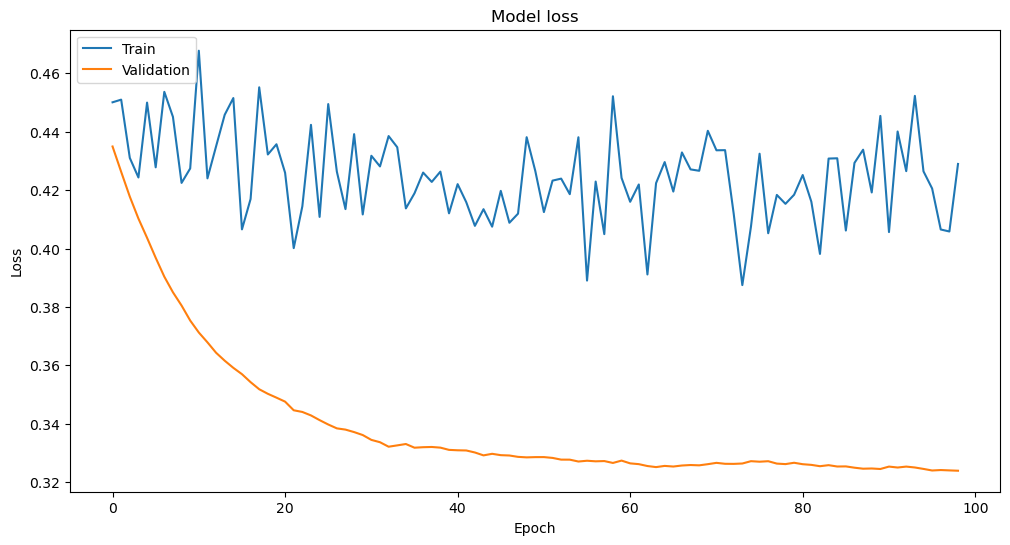

In [7]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the distances on the validation set
val_predictions = model.predict(val_images)

# Reshaping predictions and true values to one-dimensional arrays
val_predictions = val_predictions.reshape(-1)
true_values = center_depths_val.reshape(-1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae} meters")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, val_predictions)
print(f"Mean Squared Error (MSE): {mse} meters")

15/15 [==============================] - 6s 241ms/step
Mean Absolute Error (MAE): 0.39375805854797363 meters
Mean Squared Error (MSE): 0.3239290118217468 meters


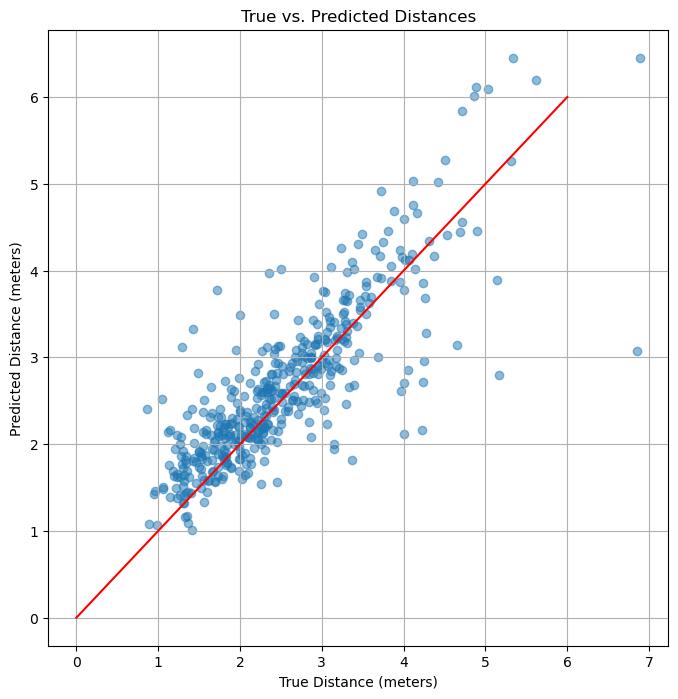

In [9]:
import matplotlib.pyplot as plt

# Scatter plot of true vs. predicted distances
plt.figure(figsize=(8, 8))
plt.scatter(true_values, val_predictions, alpha=0.5)
plt.plot([0, 6], [0, 6], color='red')  # Ideal model would follow this line
plt.xlabel('True Distance (meters)')
plt.ylabel('Predicted Distance (meters)')
plt.title('True vs. Predicted Distances')
plt.grid(True)
plt.show()